In [249]:
import torch
from torch import nn
import numpy as np
from torch.func import functional_call, grad, vmap
import torchopt
from collections import OrderedDict
import matplotlib.pyplot as plt
import deepxde as dde
from pyDOE import lhs
from torch.optim import LBFGS
from torchsummary import summary

In [250]:
# !pip install deepxde
# !pip install pyDOE

### Dimensiones de varilla en 1D

In [ ]:
T = 100.0 # Tiempo de evaluación de evolución de la temperatura
L = 1.0 # Longitud de la barra
k = 0.003 # Conductividad térmica

### Cantidad de puntos de entrenamiento y prueba

In [252]:
training_size = 300
testing_size = 5000

### Función para condición inicial de varilla

In [253]:
f_x = lambda x: 50*x*(1-x)

In [ ]:
torch.manual_seed(123) # Semilla para reproducibilidad

## Generar puntos de boundary conditions

In [ ]:
# Generar puntos de boundary conditions y condiciones iniciales
def generate_boundary_and_initial_conditions(N):
    # Generacion de una meshgrid para los puntos de boundary e initial conditions, de coordenada espacial x y tiempo t
    x = torch.linspace(0, L, N).view(-1, 1)
    t = torch.linspace(0, T, N).view(-1, 1)
    x, t = torch.meshgrid(x.squeeze(1), t.squeeze(1))

    # initial condition

    # Usar cualquier X y forzar a que el tiempo sea 0
    # en todos los puntos segun la condición inicial u(x, 0) = f(x)
    x_left = torch.hstack((x[:, 0][:, None], t[:, 0][:, None]))
    y_left = f_x(x_left[:, 0]).unsqueeze(1)
    print(y_left.shape)
    

    # boundary condition

    # Usar cualquier T y forzar a que la x sea 0
    x_bottom = torch.hstack((x[0, :][:, None], t[0, :][:, None]))
    y_bottom = torch.zeros(x_bottom.shape[0], 1)
    

    # Usar cualquier T y forzar a que x sea L
    x_top = torch.hstack((x[-1, :][:, None], t[-1, :][:, None]))
    y_top = torch.zeros(x_top.shape[0], 1)

    X_train = torch.vstack([x_left, x_bottom, x_top])
    y_train = torch.vstack([y_left, y_bottom, y_top])

    

    return X_train, y_train

In [ ]:
X_bc, y_bc = generate_boundary_and_initial_conditions(training_size)

torch.Size([300, 1])


### Red neuronal Feedforward

In [ ]:
class FCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(FCN, self).__init__()
        activation = nn.Tanh
        self.net = nn.Sequential(OrderedDict([
            ('input', nn.Linear(input_size, hidden_size)),
            ('act0', activation()),
            ('hidden', nn.ModuleList([nn.Sequential(OrderedDict([
                ('linear', nn.Linear(hidden_size, hidden_size)),
                ('act', activation())
            ])) for _ in range(num_layers)])),
            ('output', nn.Linear(hidden_size, output_size))
        ]))


    def forward(self, x):
        x = self.net[0](x)  # Input layer
        x = self.net[1](x)  # Activation after input layer
        for layer in self.net[2]:  # Loop through each hidden layer
            x = layer(x)
        x = self.net[3](x)  # Output layer
        return x

In [259]:
model = FCN(2, 20, 2, 1)

In [260]:
summary(model, input_size=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]              60
              Tanh-2                   [-1, 20]               0
            Linear-3                   [-1, 20]             420
              Tanh-4                   [-1, 20]               0
            Linear-5                   [-1, 20]             420
              Tanh-6                   [-1, 20]               0
            Linear-7                    [-1, 1]              21
Total params: 921
Trainable params: 921
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [261]:
loss_function = nn.MSELoss(reduction='mean')

## Pérdida física

Acá es donde se integran las ecuaciones diferenciales. En este caso, la ecuación de calor en 1D.

In [262]:
def physics_loss(X, model):
    x, t = X[:, 0:1], X[:, 1:2]
    data = torch.hstack((x, t))
    u = model(data)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    u = u_t - k * u_xx

    return torch.mean(u**2)

## Pérdida de BCs
Acá se usa un enfoque tradicional de una red neuronal, donde se ingresan las coordenadas x y el tiempo, el ground truth está establecido en el dataset y se compara el output de la red con el ground truth.

In [263]:
def boundary_loss(model):
    u = model(X_bc)
    return loss_function(u, y_bc)

## Pérdida de PINN
Se integra la pérdida física y la pérdida de BCs para asegurar que la red neuronal aprenda tanto las ecuaciones diferenciales como las condiciones de frontera.

In [264]:
def loss_calc(X, model, w_physics, w_boundary):
    # print(physics_loss(X, model))
    # print(boundary_loss(model))
    return w_physics * physics_loss(X, model) + w_boundary * boundary_loss(model)

## Puntos de colocación
Se generan puntos de colocación para evaluar la ecuación de calor en 1D y minimizar la phyisics loss a 0.

In [265]:
def generate_training_data(N):
    x = torch.linspace(0, L, N).view(-1, 1)
    t = torch.linspace(0, T, N).view(-1, 1)
    # x = torch.tensor(LHS_sampling(N, 1, 0, L), requires_grad=True).view(-1, 1)
    # t = torch.tensor(LHS_sampling(N, 1, 0, T), requires_grad=True).view(-1, 1)
    # x = x.type(torch.FloatTensor)
    # t = t.type(torch.FloatTensor)
    x, t = torch.meshgrid(x.squeeze(1), t.squeeze(1))

    X_train = torch.hstack((x.flatten()[:, None], t.flatten()[:, None]))
    y_train = f_x(X_train[:, 0])

    X_train = torch.tensor(X_train, requires_grad=True)
    y_train = torch.tensor(y_train, requires_grad=True)

    return X_train, y_train

## Entrenamiento

In [266]:
num_epochs = 5000
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = LBFGS(model.parameters(), lr=0.01)
X_train, y_train = generate_training_data(training_size)
X_train.shape

C:\Users\Daniel\AppData\Local\Temp\ipykernel_5948\2262531803.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, requires_grad=True)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_5948\2262531803.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, requires_grad=True)


torch.Size([90000, 2])

In [267]:
w_physics = 1
w_boundary = 1

In [268]:
losses = []

In [269]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    def closure():
        # Limpiar los gradientes antes de calcular la pérdida
        optimizer.zero_grad()
        # Calcular la pérdida
        loss = loss_calc(X_train, model, w_physics, w_boundary)
        # Realizar el paso hacia atrás
        loss.backward()
        # Retornar la pérdida para que LBFGS pueda usarla
        return loss
    loss = loss_calc(X_train, model, w_physics, w_boundary)
    loss.backward()
    optimizer.step()
    # optimizer.step(closure)

    # loss = closure()

    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')

Epoch [0/5000], Loss: 27.928579330444336
Epoch [100/5000], Loss: 4.737290382385254
Epoch [200/5000], Loss: 3.704228401184082
Epoch [300/5000], Loss: 3.597856283187866
Epoch [400/5000], Loss: 3.4308862686157227
Epoch [500/5000], Loss: 3.2162551879882812
Epoch [600/5000], Loss: 0.04141167551279068
Epoch [700/5000], Loss: 0.02264365740120411
Epoch [800/5000], Loss: 0.019490109756588936
Epoch [900/5000], Loss: 0.021853838115930557
Epoch [1000/5000], Loss: 0.00888198334723711
Epoch [1100/5000], Loss: 0.020154915750026703
Epoch [1200/5000], Loss: 0.007891099900007248
Epoch [1300/5000], Loss: 0.024929150938987732
Epoch [1400/5000], Loss: 0.010271900333464146
Epoch [1500/5000], Loss: 0.04658564180135727
Epoch [1600/5000], Loss: 0.011548019014298916
Epoch [1700/5000], Loss: 0.02260148525238037
Epoch [1800/5000], Loss: 0.008648214861750603
Epoch [1900/5000], Loss: 0.0038917027413845062
Epoch [2000/5000], Loss: 0.006552267353981733
Epoch [2100/5000], Loss: 0.0031089356634765863
Epoch [2200/5000],

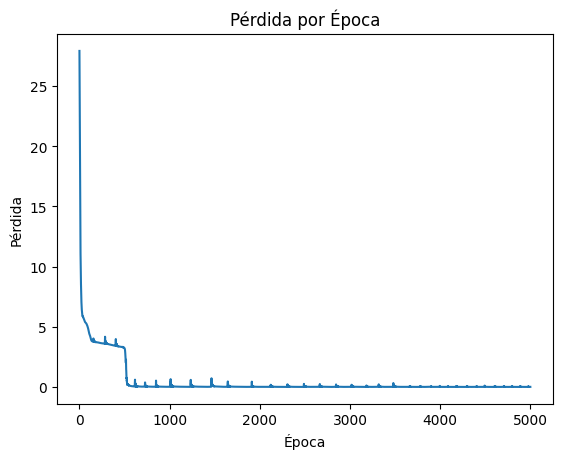

In [198]:
plt.plot(losses)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida por Época')
plt.show()

In [199]:
x_eval = torch.linspace(0, L, testing_size).view(-1, 1)
t_eval = torch.linspace(0, T, testing_size).view(-1, 1)
print(x_eval.shape, t_eval.shape)
x_eval, t_eval = torch.meshgrid(x_eval.squeeze(1), t_eval.squeeze(1))

torch.Size([5000, 1]) torch.Size([5000, 1])


In [200]:
# load model from pth dictionary
model.load_state_dict(torch.load('models/model_heat.pth'))

<All keys matched successfully>

In [201]:
X_test = torch.hstack((x_eval.flatten()[:, None], t_eval.flatten()[:, None]))

u = model(X_test)
u = u.reshape([x_eval.shape[0], t_eval.shape[0]]).detach().cpu()
# u = u.reshape(x_eval.shape)
print(u.shape)

torch.Size([5000, 5000])


In [202]:
# save model
torch.save(model.state_dict(), 'models/model_heat.pth')

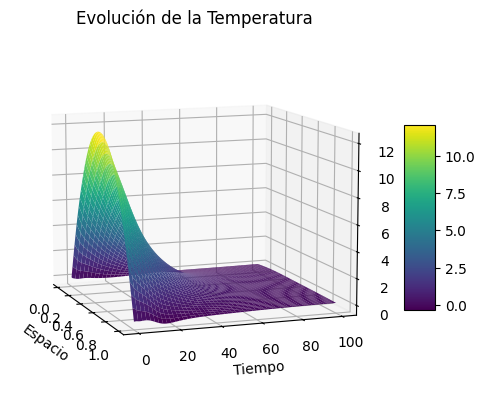

In [236]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Crear la superficie
surf = ax.plot_surface(x_eval, t_eval, u, cmap='viridis')

# Configuración de la vista
ax.view_init(elev=10, azim=-20)

# Agregar etiquetas a los ejes
ax.set_xlabel('Espacio')
ax.set_ylabel('Tiempo')
ax.set_zlabel('Temperatura')
ax.set_title('Evolución de la Temperatura')

# Añadir una barra de color
fig.colorbar(surf, shrink=0.5, aspect=6)

# plt.savefig('heat-result-PINN.pdf', format='pdf')

# Mostrar el gráfico
plt.show()

## Condición inicial
Este gráfico representa la temperatura inicial de todos los puntos x de la varilla en el tiempo inicial t=0.

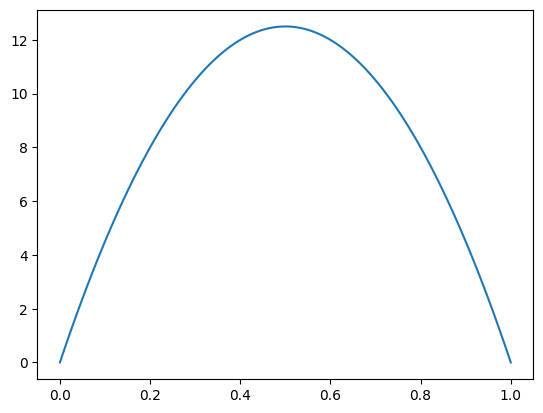

In [204]:
x_eval_f = np.linspace(0, L, 100)
x_eval_f = torch.tensor(x_eval_f, requires_grad=True)
x_prueba = f_x(x_eval_f).detach().numpy()
plt.plot(x_eval_f.detach().numpy(), x_prueba)
plt.show()

## Compraración de resultados con método de diferencias finitas

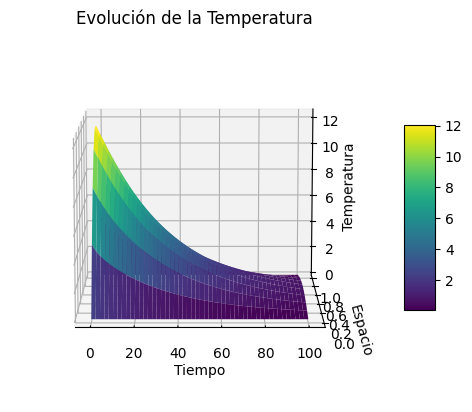

In [271]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros (puedes reutilizar los del ejemplo anterior)
L = 1.0
nx = 10
alpha = 0.003
dx = L / (nx - 1)
nt = 1000
dt = 0.1

# Condición inicial y malla espacial
x = np.linspace(0, L, nx)
f = 50*x * (1-x)

# Inicializar la matriz de temperaturas
u_df = np.zeros((nt, nx))
u_df[0, :] = f.copy()

# Método de diferencias finitas (adaptado para almacenar resultados)
for n in range(1, nt):
    for i in range(1, nx - 1):
        u_df[n, i] = u_df[n-1, i] + alpha * dt / dx**2 * (u_df[n-1, i+1] - 2*u_df[n-1, i] + u_df[n-1, i-1])

# Crear una malla de espacio y tiempo
T, X = np.meshgrid(np.linspace(0, nt*dt, nt), x)
# Crear el gráfico 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T, X, u_df.T, cmap='viridis')
ax.view_init(elev=10, azim=-90)

# Añadir una barra de color
fig.colorbar(surf, shrink=0.5, aspect=6)

# Etiquetas y título
ax.set_xlabel('Tiempo')
ax.set_ylabel('Espacio')
ax.set_zlabel('Temperatura')
ax.set_title('Evolución de la Temperatura')

# plt.savefig('heat-result-FD-2.pdf', format='pdf')

# Mostrar el gráfico
plt.show()


In [206]:
X_t = torch.tensor(X, requires_grad=True, dtype=torch.float32)
T_t = torch.tensor(T, requires_grad=True, dtype=torch.float32)
XT = torch.stack([X_t.ravel(), T_t.ravel()], axis=1)
u2 = model(XT)
u2 = u2.reshape(X_t.shape).detach().numpy().T

In [207]:
u_df.shape

(1000, 10)

In [208]:
u2.shape

(1000, 10)

In [273]:
def error_l2_norm(u_pred, u_true):
    # Calcular la norma L2 del error (predicciones - valores reales)
    error_u_predict = torch.norm(u_pred - u_true, dim=1, p=2)
    
    # Calcular la media del error L2 norm
    error_u_predict_mean = error_u_predict.mean()
    
    return error_u_predict_mean, error_u_predict

# Error L2 norm relativo
def relative_error_l2_norm(u_pred, u_true, epsilon=1e-8):
    # Calcular el error L2 norm de las predicciones
    error_u_predict = torch.norm(u_pred - u_true, dim=1, p=2)
    
    # Calcular la norma L2 de los valores reales
    norm_u_real = torch.norm(u_true, dim=1, p=2)
    
    # Evitar división por cero añadiendo un pequeño valor epsilon
    rela_error = error_u_predict / (norm_u_real + epsilon)
    
    # Calcular la media del error relativo
    rela_error_mean = rela_error.mean()
    
    return rela_error_mean, rela_error

In [277]:
u2 = torch.tensor(u2, dtype=torch.float32)
u_df = torch.tensor(u_df, dtype=torch.float32)

l2_error_mean, l2_error = error_l2_norm(u2, u_df)
rel_error_mean, rel_error = relative_error_l2_norm(u2, u_df)

print(f'Error L2 medio: {l2_error_mean}')
print(f'Error relativo medio: {rel_error_mean}')

Error L2 medio: 3.685727119445801
Error relativo medio: 0.609654426574707


C:\Users\Daniel\AppData\Local\Temp\ipykernel_5948\1350656271.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u2 = torch.tensor(u2, dtype=torch.float32)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_5948\1350656271.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_df = torch.tensor(u_df, dtype=torch.float32)
